Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import glob
import time
import re
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

Importing Database

In [2]:
df = pd.read_csv('data.csv')
df = df.rename(columns={"Primary Type":"PrimaryType"}) #change the column name to remove whitespace

In [39]:
df['PrimaryType'].value_counts() #occurence of each crime type

THEFT                                1512031
BATTERY                              1311392
CRIMINAL DAMAGE                       815476
NARCOTICS                             731985
ASSAULT                               451637
OTHER OFFENSE                         444675
BURGLARY                              404155
MOTOR VEHICLE THEFT                   329396
DECEPTIVE PRACTICE                    287771
ROBBERY                               268863
CRIMINAL TRESPASS                     203548
WEAPONS VIOLATION                      81713
PROSTITUTION                           69281
PUBLIC PEACE VIOLATION                 50391
OFFENSE INVOLVING CHILDREN             49468
CRIM SEXUAL ASSAULT                    28398
SEX OFFENSE                            27266
INTERFERENCE WITH PUBLIC OFFICER       17272
GAMBLING                               14584
LIQUOR LAW VIOLATION                   14388
ARSON                                  11885
HOMICIDE                               10479
KIDNAPPING

In [4]:
df = df.dropna() #remove rows including null values
df = df.drop(df.index[(df.PrimaryType == 'DOMESTIC VIOLENCE') | (df.PrimaryType =='NON-CRIMINAL (SUBJECT SPECIFIED)') | (df.PrimaryType =='RITUALISM')]) #since we want to make several models with different size and using kfold, output classes with small number of occurence will raise error
df = df.reset_index(drop = True)
df['PrimaryType'].value_counts().shape #number of crime types

(33,)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7154339 entries, 0 to 7154338
Data columns (total 9 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   index                 int64 
 1   Primary Type          object
 2   Location Description  object
 3   Year                  int64 
 4   Month                 int64 
 5   day                   int64 
 6   day_of_week           object
 7   weekday               object
 8   Day_Period            object
dtypes: int64(4), object(5)
memory usage: 491.2+ MB


In [46]:
#different classes of columns with object data type
print(df['Day_Period'].unique())
print(df['weekday'].unique())
print(df['day_of_week'].unique())
print(df['Location Description'].unique())

['6am - 2pm' '10pm - 6am' '2pm - 10pm']
['Weekday' 'Weekend']
['Monday' 'Sunday' 'Tuesday' 'Saturday' 'Thursday' 'Friday' 'Wednesday']


In [5]:
df_mod = df.copy()

In [6]:
#mapping weekday to binary classes
df_mod['weekday'] = df_mod['weekday'].map({'Weekday' : 0, 'Weekend':1})
df_mod = df_mod.rename(columns={"weekday":"weekend"})

In [7]:
#encode datas with several classes using labelencoder
label = preprocessing.LabelEncoder()
encoder = pd.DataFrame(label.fit_transform(df_mod[['Location Description']]))
df_mod['Location Description'] = encoder
encoder = pd.DataFrame(label.fit_transform(df_mod[['day_of_week']]))
df_mod['day_of_week'] = encoder
encoder = pd.DataFrame(label.fit_transform(df_mod[['Day_Period']]))
df_mod['Day_Period'] = encoder
encoder = pd.DataFrame(label.fit_transform(df_mod[['PrimaryType']]))
df_mod['PrimaryType'] = encoder

C:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PrimaryType,Location Description,Year,Month,day,day_of_week,weekend,Day_Period
0,9,158,2001,1,1,1,0,2
1,5,158,2017,10,8,3,1,0
2,3,139,2017,3,28,5,0,1
3,31,158,2017,9,9,2,1,1
4,5,114,2017,8,26,2,1,2


In [7]:
df_mod.corr(method='pearson', min_periods=1) #find the correlation of features

,Location Description,Year,Month,day,day_of_week,weekend,Day_Period
Location Description,1.000000,-0.054140,0.005943,0.003029,0.003604,-0.007276,-0.024197
Year,-0.054140,1.000000,-0.025071,-0.000951,-0.004098,0.007656,0.025796
Month,0.005943,-0.025071,1.000000,0.000789,-0.002827,0.006756,-0.007680
day,0.003029,-0.000951,0.000789,1.000000,0.001378,0.000834,-0.000987
day_of_week,0.003604,-0.004098,-0.002827,0.001378,1.000000,-0.153148,0.026362
weekend,-0.007276,0.007656,0.006756,0.000834,-0.153148,1.000000,-0.092816
Day_Period,-0.024197,0.025796,-0.007680,-0.000987,0.026362,-0.092816,1.000000


In [10]:
df_mod_reduced = df_mod.sample(1000000, random_state=1)

In [11]:
X = df_mod_reduced.iloc[:,1:]
y = df_mod_reduced.iloc[:,0]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [13]:
#make sure we have all types of crime both in y train and y test
y_train.unique().shape, y.unique().shape, df_mod_reduced['PrimaryType'].unique().shape, df['PrimaryType'].unique().shape

((35,), (35,), (35,), (35,))

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [72]:
kfold = KFold(n_splits = 5, shuffle = True, random_state =1)

In [9]:
classifiers = []
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
NB = GaussianNB()
DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
RF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
XGB = XGBClassifier(n_estimators=10,max_depth = 5,gamma = 0)
classifiers.append(KNN)
classifiers.append(NB)
classifiers.append(DT)
classifiers.append(RF)
classifiers.append(XGB)
classifiers_names = ['KNN', 'NB', 'DT', 'RF', 'XGB']

In [139]:
results = []
for i in range(len(classifiers)):    
    print(classifiers_names[i], cross_val_score(classifiers[i], X, y, cv=kfold, scoring='accuracy').mean()) #finding best model

KNN 0.22878333333333334
NB 0.23286166666666666
DT 0.216675
RF 0.22196833333333332
XGB 0.31926333333333334


In [28]:
for i in range(X.shape[1]):
    print('feature', i, X.columns[i], XGB.feature_importances_[i]) #identifying most important features

feature 0 Location Description 0.6616389
feature 1 Year 0.05895941
feature 2 Month 0.033312537
feature 3 day 0.012722195
feature 4 day_of_week 0.011096984
feature 5 weekend 0.07535238
feature 6 Day_Period 0.14691757


In [74]:
df_mod = df_mod.drop(['day_of_week', 'day'], axis=1) #removing least important features, considering their overlap with other features

In [12]:
#exploring the effect of data size on the accuracy of the model
xgboost = []
xgb_size = []
for i in range(1,2):
    df_resize = df_mod.sample(3000000*i, random_state=1)
    X = df_resize.iloc[:,1:]
    y = df_resize.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    xgboost.append(cross_val_score(XGB, X, y, cv=5, scoring='accuracy').mean())
    xgb_size.append(i*300000)


In [13]:
xgboost

[0.3192183333333333]

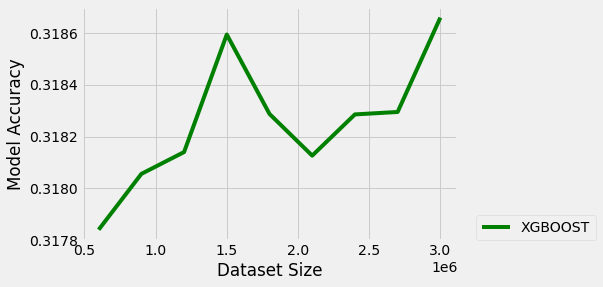

In [76]:
plt.style.use('fivethirtyeight')
plt.plot(xgb_size, xgboost, c = 'green', label = 'XGBOOST')
plt.xlabel('Dataset Size')
plt.ylabel('Model Accuracy')
plt.legend(loc =(1.05,0))

In [77]:
from sklearn.model_selection import GridSearchCV

In [79]:
#hyperparameter tuning
XGB = XGBClassifier(n_estimators=10,max_depth = 5,gamma = 0)
parameters = [{'n_estimators': [10, 30, 70, 100], 'gamma': [0, 0.01, 0.05, 0.1], 'learning_rate':[0.1, 0.3, 0.7]}]
df_mod_reduced = df_mod.sample(3000000, random_state=1)
X = df_mod_reduced.iloc[:,1:]
y = df_mod_reduced.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [80]:
grid_search = GridSearchCV(estimator= XGB,
                          param_grid= parameters,
                          scoring='accuracy',
                          cv = 5,
                          n_jobs=-1)
grid_search.fit(X_train, y_train)

[05:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_t...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                     

In [85]:
grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

(0.3188833333333333, {'gamma': 0.05, 'learning_rate': 0.3, 'n_estimator': 10})

In [99]:
parameters = [{'n_estimators': [10, 30, 70, 100]}]
XGB = XGBClassifier(n_estimators=10,max_depth = 5,gamma = 0.05, learning_rate = 0.3)
grid_search = GridSearchCV(estimator= XGB,
                          param_grid= parameters,
                          scoring='accuracy',
                          cv = 5,)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0.05, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
        

In [12]:
#modeling with tuned hyperparameters, exploring different data size
XGB = XGBClassifier(n_estimators=100,max_depth = 5,gamma = 0.05, learning_rate = 0.3)
xgboost = []
xgb_size = []
for i in range(5):
    df_resize = df_mod.sample(1000000*(i+1), random_state=1)
    X = df_resize.iloc[:,1:]
    y = df_resize.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)
    xgboost.append(cross_val_score(XGB, X, y, cv=2, scoring='accuracy').mean())
    xgb_size.append((i+1)*1000000)
    print(i)

0
1
2
3
4


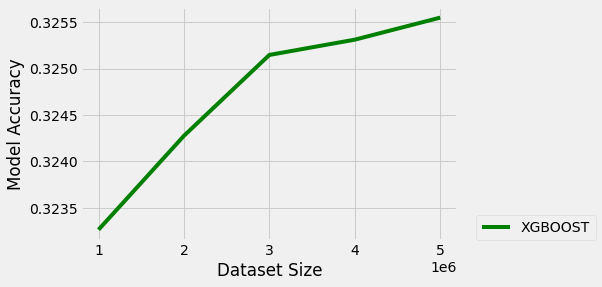

In [13]:
plt.style.use('fivethirtyeight')
plt.plot(xgb_size, xgboost, c = 'green', label = 'XGBOOST')
plt.xlabel('Dataset Size')
plt.ylabel('Model Accuracy')
plt.legend(loc =(1.05,0))